In [1]:
cd ..

/home/araxal/coursework


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from utils.genre_classification import plot_confusion_matrix
from utils.genre_classification import evaluate, executor, feature_preparator, random_features_slicer

In [3]:
def transformer(x):
    x = random_features_slicer(x)
    return permute_channels(x)

def permute_channels(x: np.ndarray):
    # channel time, mfcc
    return x.reshape((256, 3, 24)).transpose((1, 0, 2))

In [4]:
BATCH_SIZE = 64
NUM_CLASSES = 8
DEVICE = torch.device('cuda')

In [5]:
%%time
train_data_loader, val_data_loader, test_data_loader, idx_to_label = feature_preparator(
    'features/genre_classification/mfcc24-3d-delta.p',
    BATCH_SIZE,
    transform=transformer
)

CPU times: user 4.34 s, sys: 2.33 s, total: 6.67 s
Wall time: 6.81 s


In [6]:
next(iter(train_data_loader))[0].shape

torch.Size([64, 3, 256, 24])

In [7]:
train_labels = []
val_labels = []
test_labels = []

for x, label in train_data_loader:
    train_labels.append(label)

for x, label in val_data_loader:
    val_labels.append(label)

for x, label in test_data_loader:
    test_labels.append(label)

print('Train', np.unique(torch.cat(train_labels).numpy(), return_counts=True))
print('Val', np.unique(torch.cat(val_labels).numpy(), return_counts=True))
print('Test', np.unique(torch.cat(test_labels).numpy(), return_counts=True))

Train (array([0, 1, 2, 3, 4, 5, 6, 7]), array([1166, 1180, 1174, 1158, 1169, 1175, 1104, 1154]))
Val (array([0, 1, 2, 3, 4, 5, 6, 7]), array([251, 250, 252, 247, 251, 251, 236, 246]))
Test (array([0, 1, 2, 3, 4, 5, 6, 7]), array([250, 253, 251, 245, 249, 253, 236, 247]))


In [8]:
def plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy']):
    fig, axes = plt.subplots(len(metrics), 2)
    for i in range(len(metrics)):
        axes[i][0].plot(train_progress[:, i])
        axes[i][0].set_title(f'train_{metrics[i]}')
        axes[i][1].plot(val_progress[:, i])
        axes[i][1].set_title(f'val_{metrics[i]}')

def transform_idx_to_label(x):
    return idx_to_label[x]

Перцептрон

In [9]:
from torch import nn


def linear_block(in_dim, out_dim):
    return nn.Sequential(
        nn.Linear(in_dim, out_dim),
        nn.BatchNorm1d(out_dim),
        nn.ReLU(out_dim),
        nn.Dropout(0.1),
    )


class FeedForwardModel(nn.Module):
    def __init__(self, input_dim, num_class):
        super(FeedForwardModel, self).__init__()

        self.layer_1 = linear_block(input_dim, 1024)
        self.layer_2 = linear_block(1024, 512)
        self.layer_3 = linear_block(512, 512)
        self.layer_4 = linear_block(512, 128)
        self.layer_out = nn.Linear(128, num_class)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x1 = self.layer_1(x)

        x2 = self.layer_2(x1)

        x3 = self.layer_3(x2)

        x4 = self.layer_4(x3 + x2)

        x5 = self.layer_out(x4)

        return x5


 58%|█████▊    | 58/100 [05:51<04:14,  6.07s/it]

Early stop!


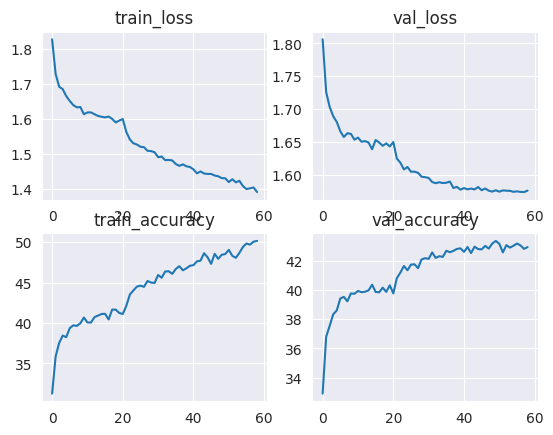

In [32]:
ff_model = FeedForwardModel(3 * 256 * 24, NUM_CLASSES).to(DEVICE)
train_progress, val_progress = executor(DEVICE, ff_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=100, learning_rate=0.0001, weight_decay=0.01, evaluate_per_iteration=10, early_stop_after=(10,  0.001))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

       Blues       0.52      0.44      0.48       248
   Classical       0.61      0.66      0.63       252
  Electronic       0.34      0.37      0.35       249
        Folk       0.37      0.36      0.36       249
     Hip-Hop       0.50      0.64      0.57       252
        Jazz       0.32      0.37      0.35       252
         Pop       0.26      0.15      0.19       234
        Rock       0.47      0.49      0.48       248

    accuracy                           0.44      1984
   macro avg       0.43      0.43      0.43      1984
weighted avg       0.43      0.44      0.43      1984



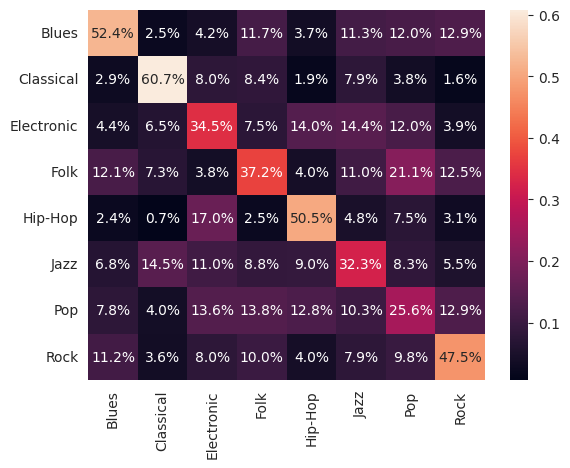

In [34]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, ff_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred, idx_to_label, transform_idx_to_label)

## Свертка по времени

In [10]:
def calculate_shape(x, n_layers=4):
    for i in range(n_layers):
        x = (x - 4) / 2

    return int(x)

def conv_block(in_ch, out_ch, kernel_size, pooling_kernel_size):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size),
        nn.MaxPool2d(pooling_kernel_size),
        nn.BatchNorm2d(out_ch),
        nn.ReLU()
    )

In [13]:
from torch import nn

# Свертка по времени
class Conv1Model(nn.Module):
    def __init__(self, num_class, time_size, feature_size = 128):
        super(Conv1Model, self).__init__()

        self.conv1 = conv_block(3, 16, (5, 1), (2, 1))
        self.conv2 = conv_block(16, 32, (5, 1), (2, 1))
        self.conv3 = conv_block(32, 32, (5, 1), (2, 1))
        self.conv4 = conv_block(32, 32, (5, 1), (2, 1))

        self.linear_1 = linear_block(32 * feature_size * calculate_shape(time_size), 256)
        self.linear_2 = linear_block(256, 256)
        self.linear_3 = linear_block(256, 256)
        self.linear_4 = linear_block(256, 256)

        self.linear_out = linear_block(256, num_class)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.flatten(start_dim=1)

        x1 = self.linear_1(x)
        x2 = self.linear_2(x1) + x1
        x3 = self.linear_3(x2) + x2
        x4 = self.linear_4(x3) + x3

        return self.linear_out(x4)



 38%|███▊      | 38/100 [02:12<03:35,  3.47s/it]

Early stop!


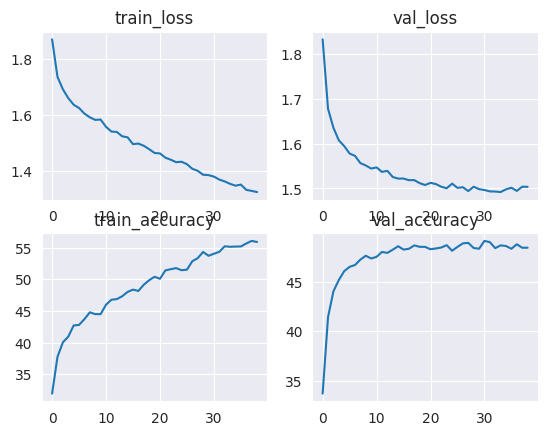

In [14]:
conv_1_model = Conv1Model(NUM_CLASSES, time_size=256, feature_size=24).to(DEVICE)
train_progress, val_progress = executor(DEVICE, conv_1_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=100, learning_rate=0.0001, weight_decay=0.01, evaluate_per_iteration=10, early_stop_after=(15,  0.01))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

       Blues       0.55      0.48      0.52       249
   Classical       0.62      0.71      0.66       253
  Electronic       0.40      0.39      0.40       251
        Folk       0.40      0.46      0.43       246
     Hip-Hop       0.55      0.71      0.62       251
        Jazz       0.42      0.42      0.42       252
         Pop       0.31      0.21      0.25       236
        Rock       0.46      0.41      0.43       246

    accuracy                           0.48      1984
   macro avg       0.46      0.47      0.47      1984
weighted avg       0.47      0.48      0.47      1984



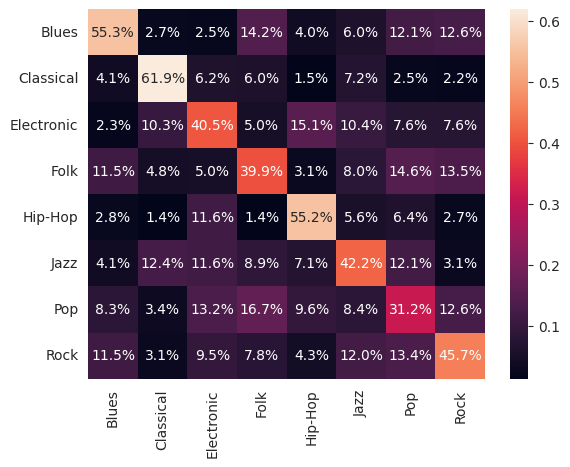

In [15]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, conv_1_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred, idx_to_label, transform_idx_to_label)